<a href="https://colab.research.google.com/github/TBHammond/Logistic-Regression-from-Scratch-with-PyRorch/blob/main/logistic_regression_from_scratch_pytorch_gh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistic Regression from Scratch Using PyTorch - Data Extraction
This notebook contains for an image classifier using logistic regression. The SEN12FLOOD dataset (https://ieee-dataport.org/open-access/sen12-flood-sar-and-multispectral-dataset-flood-detection) is utilized for training and validating the model.

In [ ]:
## Import the usual libraries
import torch
import torchvision
import torch.nn as nn
from torchvision import datasets, models, transforms
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

%matplotlib inline

## print out the pytorch version used (1.31 at the time of this tutorial)
print(torch.__version__)

1.12.1+cu113


In [ ]:
## configuration to detect cuda or cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print (device)

cuda:0


## Data Extraction

In [ ]:
# Examine information about the dataset stored in json files provided with the source dataset.
# Be sure to mount your Google Drive directory by selceting Files > click on folder containing Google Drive logo.

import json

f = open(r"/content/drive/MyDrive/Learning/LR_from_scratch_pytorch/raw_data/S1list.json")
f1 = open(r"/content/drive/MyDrive/Learning/LR_from_scratch_pytorch/raw_data/S2list.json")

S1list = json.load(f)
S2list = json.load(f1)

In [ ]:
# Print the jsons in order to examine the file structure. This will give you information about the source dataset structure.

import pprint

# construct PrettyPrinter first
pp = pprint.PrettyPrinter(indent=4, width=80, compact=False)

pp.pprint(S1list)

Streaming output truncated to the last 5000 lines.
                         'orbit': 'DESCENDING'},
                '6': {   'FLOODING': True,
                         'date': '2019-02-12',
                         'filename': 'S1B_IW_GRDH_1SDV_20190212T084222_20190212T084251_014910_01BD61_C22B',
                         'orbit': 'ASCENDING'},
                '7': {   'FLOODING': True,
                         'date': '2019-02-23',
                         'filename': 'S1A_IW_GRDH_1SDV_20190223T194432_20190223T194457_026061_02E7F3_3C3A',
                         'orbit': 'DESCENDING'},
                '8': {   'FLOODING': True,
                         'date': '2019-03-07',
                         'filename': 'S1A_IW_GRDH_1SDV_20190307T194432_20190307T194457_026236_02EE37_2A1B',
                         'orbit': 'DESCENDING'},
                'count': 8,
                'folder': '0320',
                'geo': {   'coordinates': [   [   [146.802617, -19.276917],
                      

In [ ]:
pp.pprint(S2list)

Streaming output truncated to the last 5000 lines.
                          'date': '2019-05-16'},
                '24': {   'FLOODING': True,
                          'FULL-DATA-COVERAGE': True,
                          'date': '2019-05-18'},
                '3': {   'FLOODING': False,
                         'FULL-DATA-COVERAGE': True,
                         'date': '2019-03-04',
                         'filename': 'S2_2019-03-04'},
                '4': {   'FLOODING': False,
                         'FULL-DATA-COVERAGE': True,
                         'date': '2019-03-07',
                         'filename': 'S2_2019-03-07'},
                '5': {   'FLOODING': False,
                         'FULL-DATA-COVERAGE': True,
                         'date': '2019-03-09',
                         'filename': 'S2_2019-03-09'},
                '6': {   'FLOODING': False,
                         'FULL-DATA-COVERAGE': True,
                         'date': '2019-03-12',
            

In [ ]:
# Delete dictionaries missing filenames in S1list and S2list.
# Many of the dictionaries in the jsons omit the image filenames and thus are useless.

def remove_dicts(obj, key):
  arr = []
  for d1 in obj.values():    # top level is a dict
    for d2 in d1.values():
          # level below is also a dict
      if 'filename' not in str(d2):
          continue          # disregard this one, it is incomplete
      if key in d2:
          arr.append(d2[key]) # extract value
  return arr

In [ ]:
dateS1 = remove_dicts(S1list, 'date')
floodingS1 = remove_dicts(S1list, 'FLOODING')
filenameS1 = remove_dicts(S1list, 'filename')

len(dateS1)==len(floodingS1)==len(filenameS1)

True

In [ ]:
dateS2 = remove_dicts(S2list, 'date')
floodingS2 = remove_dicts(S2list, 'FLOODING')
filenameS2 = remove_dicts(S2list, 'filename')

len(dateS2)==len(floodingS2)==len(filenameS2)

True

In [ ]:
# Create a dataframe of all of the files.

filesDF1 = pd.DataFrame({"Image":filenameS1,"Date":dateS1, "Flooding":floodingS1})
filesDF1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3957 entries, 0 to 3956
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Image     3957 non-null   object
 1   Date      3957 non-null   object
 2   Flooding  3957 non-null   bool  
dtypes: bool(1), object(2)
memory usage: 65.8+ KB


In [ ]:
filesDF2 = pd.DataFrame({"Image":filenameS2,"Date":dateS2, "Flooding":floodingS2})
filesDF2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2237 entries, 0 to 2236
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Image     2237 non-null   object
 1   Date      2237 non-null   object
 2   Flooding  2237 non-null   bool  
dtypes: bool(1), object(2)
memory usage: 37.3+ KB


In [ ]:
## Concatenate into a single DF.

filesDF = pd.concat([filesDF1,filesDF2], ignore_index=True)
filesDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6194 entries, 0 to 6193
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Image     6194 non-null   object
 1   Date      6194 non-null   object
 2   Flooding  6194 non-null   bool  
dtypes: bool(1), object(2)
memory usage: 103.0+ KB


In [ ]:
# Sanity check for the length of the combined dataframe.

len(filesDF['Image'])-len(filesDF['Image'].drop_duplicates())

5819

In [ ]:
# Drop duplicate filenames

filesDF = filesDF.drop_duplicates()
len(filesDF)

381

## Training and Test Sets Extraction

*Stratified sampling is used for extracting training and testing sets since the number of Flooding False versus True values is significantly unequal.*

In [ ]:
X = filesDF[['Image', 'Date']].to_numpy()
y = filesDF[['Flooding']].to_numpy()

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
sss.get_n_splits(X, y)

5

In [ ]:
for train_index, test_index in sss.split(X, y):
  print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

TRAIN: [ 91  40 185  33 126 216  28 209 232 143 100 368 359  22 160 358 347  16
  64 134  58 110 223  81  95 340  10 369 153 136 365 231 203 141  45 338
 127 314 132  61 309 225  29 122  68 256 206 205 310 265  87  84 290  24
 376   1 152 263 104 165 257 267 226 288 294 254 174  67 213 334 233 323
 262 176 240 264 325 329  54 318 193 327 178  27 117 159  77 109  99 207
 328 316 249 380  53 363 330 164 114 287 298 224 105  18  35  62 356 339
 280 258  83 215   7   2 354 312 150  34 135  38 186   6 199  93 144   5
 302 324  71 374 162 140 188  20 300 227  46  11 242 200 190 282 133  32
 187 112 179 161 357  79 106 129  43 241 147 166  51 342 184 296  97 214
 348  72 301 321 379   3  21 210 292 341  31 128  44 239  82 157 355 304
 149  90  78 276   0  26 237  17 336 244 181 189  13 285 124 139 275  14
 125 229 211  47 320 293  66 319 102 371 278 303 284  85 350 230 286 163
 175 245   8 297 295  52 180 121 221 195 378 142  89 108 145 274 208 247
 266 155 255 220 146  25 326 158 116 270 119

In [ ]:
# Sanity check for the variables.

print(X_train[25])
print(y_train[25])

['S2_2019-03-10' '2019-03-10']
[ True]


**Compile files into training and validation folders.**  
* Extract all files from all folders and shuffle their order.
* Put 80% of the files in training and the remaining 20% in validation.


In [ ]:
# Get training and testing lists.

training_files = [i[0] for i in X_train]
testing_files = [i[0] for i in X_test]

print(training_files[0:10], end = ' ')
print("\n")
print(testing_files[0:10], end = ' ')

['S2_2019-04-21', 'S2_2019-04-01', 'S1A_IW_GRDH_1SDV_20190424T031707_20190424T031732_026926_03077A_B45D', 'S1A_IW_GRDH_1SDV_20190114T160455_20190114T160520_025475_02D2DC_7BCF', 'S2_2019-03-09', 'S1B_IW_GRDH_1SDV_20190128T163241_20190128T163306_014696_01B65E_5615', 'S1A_IW_GRDH_1SDV_20190328T023837_20190328T023902_026532_02F91C_018B', 'S1B_IW_GRDH_1SDV_20190320T030813_20190320T030839_015432_01CE6E_367E', 'S2_2019-01-16', 'S1A_IW_GRDH_1SDV_20190307T194432_20190307T194457_026236_02EE37_2A1B'] 

['S2_2018-12-23', 'S2_2019-01-12', 'S1B_IW_GRDH_1SDV_20190109T182548_20190109T182613_014421_01AD81_7F46', 'S1B_IW_GRDH_1SDV_20190312T162250_20190312T162319_015323_01CAFA_CAE4', 'S1B_IW_GRDH_1SDV_20190419T160654_20190419T160723_015877_01DD38_00F9', 'S1B_IW_GRDH_1SDV_20190106T161954_20190106T162019_014375_01AC0C_9980', 'S1A_IW_GRDH_1SDV_20190422T141953_20190422T142018_026904_0306AD_D8AD', 'S1A_IW_GRDH_1SDV_20190407T030840_20190407T030905_026678_02FE78_27F0', 'S1A_IW_GRDH_1SDV_20190321T025948_20190321

In [ ]:
testing2 = pd.DataFrame([i for i in X_test])
testing2.sample(20)

,0,1
64,S1A_IW_GRDH_1SDV_20190128T190811_20190128T1908...,2019-01-28
3,S1B_IW_GRDH_1SDV_20190312T162250_20190312T1623...,2019-03-12
42,S1A_IW_GRDH_1SDV_20190330T162405_20190330T1624...,2019-03-30
44,S1A_IW_GRDH_1SDV_20190213T025948_20190213T0300...,2019-02-13
38,S2_2019-03-29,2019-03-29
61,S1A_IW_GRDH_1SDV_20190211T194432_20190211T1944...,2019-02-11
57,S1B_IW_GRDH_1SDV_20190128T181740_20190128T1818...,2019-01-28
18,S2_2018-12-17,2018-12-17
40,S1A_IW_GRDH_1SDV_20190208T182631_20190208T1826...,2019-02-08
47,S1A_IW_GRDH_1SDV_20190223T031705_20190223T0317...,2019-02-23


In [ ]:
print(len(training_files))
print(len(testing_files))

304
77


In [ ]:
# Get training and testing targets

training_targets = y_train.tolist()
testing_targets = y_test.tolist()

print(training_targets[0:10], end = ' ')
print("\n")
print(testing_targets[0:10], end = ' ')

[[True], [True], [True], [False], [False], [False], [False], [True], [False], [True]] 

[[False], [False], [False], [False], [True], [False], [False], [True], [True], [False]] 

In [ ]:
## Write the lists to text files for use in file folder management

training_files_textfile = open("/content/drive/MyDrive/Learning/LR_from_scratch_pytorch/training_files.txt", "w")
for element in training_files:
    training_files_textfile.write(element + "\n")
training_files_textfile.close()

In [ ]:
testing_files_textfile = open("/content/drive/MyDrive/Learning/LR_from_scratch_pytorch/testing_files.txt", "w")
for element in testing_files:
    testing_files_textfile.write(element + "\n")
testing_files_textfile.close()

**Now we need to find out which two files in training_files_textfile are not in the training directory.**

In [ ]:
path = r"/content/drive/MyDrive/Learning/LR_from_scratch_pytorch/training"
training_dir_list = os.listdir(path)

tr_dir_list_bases = []

for filename in training_dir_list:
  tr_dir_list_bases.append(os.path.splitext(filename))

file_splits = []
for i in tr_dir_list_bases:
  file_splits.append(i[0])

### Check out i.removesuffix('.com')!!!!

new_splits = []

for i in file_splits:
  def remove_suffix(i, suffix1, suffix2, suffix3):
    if i.endswith(suffix1):
        return i[:-len(suffix1)]
    elif i.endswith(suffix2):
        return i[:-len(suffix2)]
    return i[:-len(suffix3)]
  new_splits.append(remove_suffix(i, '_corrected_VV','_B03','_B04'))

  # new_splits.append(i.removesuffix(['_corrected_VV','_B03','_B04']))



In [ ]:
[i for i in training_files if i not in new_splits]

['S1B_IW_GRDH_1SSV_20181222T172455_20181222T172531_014157_01A4ED_D2C3',
 'S1B_IW_GRDH_1SSV_20190115T172454_20190115T172530_014507_01B057_2CF1',
 'S1B_IW_GRDH_1SSV_20190103T172455_20190103T172531_014332_01AAAE_5245']

*The three missing files were not located in the entire dataset. These are believed to be abberations from the json files/filenames.*

**Create dataframes for training and test files containg filenames with extensions and flooding status.**


In [ ]:
# Get the flooding statuses for the training files

tr_statuses = []

for split in new_splits:
  tr_statuses.append(filesDF.loc[filesDF['Image']==split]['Flooding'].values)



In [ ]:
# This prints the flooding status of each training image. Copy the output and paste into Excel for saving as a csv.

for i in tr_statuses:
  print(i[0])

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
False
False
True
True
False
True
True
False
True
True
True
False
False
False
True
True
True
True
True
False
True
False
False
False
True
False
False
True
True
True
True
True
True
False
False
True
False
True
True
False
True
True
False
True
False
True
False
False
True
True
False
True
True
False
True
False
True
True
True
True
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True

In [ ]:
# Now get the image names of the training files. Copy the output and paste into Excel for saving in the csv created for the flooding statuses.

for i in new_splits:
  print(i)

S1A_IW_GRDH_1SDV_20181228T172539_20181228T172604_025228_02CA07_D6D2
S1A_IW_GRDH_1SDV_20181216T172539_20181216T172604_025053_02C3AD_F023
S1A_IW_GRDH_1SDV_20190102T173346_20190102T173411_025301_02CC97_68EA
S1A_IW_GRDH_1SDV_20181221T173412_20181221T173437_025126_02C648_B354
S1A_IW_GRDH_1SDV_20190116T190812_20190116T190837_025507_02D401_4E34
S1A_IW_GRDH_1SDV_20181216T172604_20181216T172629_025053_02C3AD_6EEA
S1A_IW_GRDH_1SDV_20181221T173347_20181221T173412_025126_02C648_A3BD
S1A_IW_GRDH_1SDV_20190104T190812_20190104T190837_025332_02CDAF_BC23
S1A_IW_GRDH_1SDV_20181228T172604_20181228T172629_025228_02CA07_C927
S1A_IW_GRDH_1SDV_20190109T172538_20190109T172603_025403_02D052_DCF0
S1A_IW_GRDH_1SDV_20190109T172603_20190109T172628_025403_02D052_A41A
S1A_IW_GRDH_1SDV_20190202T155600_20190202T155625_025752_02DD0C_8A1E
S1B_IW_GRDH_1SDV_20190205T031123_20190205T031148_014805_01B9FF_DC8A
S1A_IW_GRDH_1SDV_20190112T162031_20190112T162056_025446_02D1C1_75A7
S1A_IW_GRDH_1SDV_20181228T155601_20181228T155626

In [ ]:
print(len(new_splits))
print(len(tr_statuses))

301
301


**Now find out which test files are not in the directory.**

In [ ]:
path = r"/content/drive/MyDrive/Learning/LR_from_scratch_pytorch/testing"
testing_dir_list = os.listdir(path)

test_dir_list_bases = []

for filename in testing_dir_list:
  test_dir_list_bases.append(os.path.splitext(filename))

file_splits_tst = []
for i in test_dir_list_bases:
  file_splits_tst.append(i[0])

new_splits_tst = []

for i in file_splits_tst:
  def remove_suffix(i, suffix1, suffix2, suffix3):
    if i.endswith(suffix1):
        return i[:-len(suffix1)]
    elif i.endswith(suffix2):
        return i[:-len(suffix2)]
    return i[:-len(suffix3)]
  new_splits_tst.append(remove_suffix(i, '_corrected_VV','_B03','_B04'))

In [ ]:
[i for i in testing_files if i not in new_splits_tst]

[]

In [ ]:
# Get the flooding statuses for the testing files

tst_statuses = []

for split in new_splits_tst:
  tst_statuses.append(filesDF.loc[filesDF['Image']==split]['Flooding'].values)

In [ ]:
# This prints the flooding status of each testing image. Copy the output and paste into Excel for saving as a csv.

for i in tst_statuses:
  print(i[0])

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
False
False
True
True
True
True
False
False
True
True
False
True
True
True
True
False
False
False
True
True
False
True
False
False
False
False
False
False
False
True
False
False
True
False
False
False
False
False
False
False
False
False
True
False
False
False
False
True
True
False


In [ ]:
# Now get the image names of the testing files. Copy the output and paste into Excel for saving in the csv created for the flooding statuses.

for i in new_splits_tst:
  print(i)

S1A_IW_GRDH_1SDV_20190128T190811_20190128T190836_025682_02DA65_199F
S1A_IW_GRDH_1SDV_20190102T173411_20190102T173436_025301_02CC97_56BD
S1A_IW_GRDH_1SDV_20181223T190812_20181223T190837_025157_02C760_4C51
S1A_IW_GRDH_1SDV_20190109T155600_20190109T155625_025402_02D04C_6D15
S1B_IW_GRDH_1SDV_20190106T161954_20190106T162019_014375_01AC0C_9980
S1A_IW_GRDH_1SDV_20181219T162032_20181219T162057_025096_02C527_E0BD
S1A_IW_GRDH_1SDV_20181231T162031_20181231T162056_025271_02CB79_D859
S1B_IW_GRDH_1SDV_20181215T034418_20181215T034443_014047_01A135_E55B
S1B_IW_GRDH_1SDV_20190122T172003_20190122T172028_014609_01B396_A40E
S1B_IW_GRDH_1SDV_20181222T172813_20181222T172838_014157_01A4EE_FEA3
S1B_IW_GRDH_1SDV_20190115T172813_20190115T172838_014507_01B058_5847
S1A_IW_GRDH_1SDV_20190104T032801_20190104T032826_025322_02CD47_5519
S1B_IW_GRDH_1SDV_20190128T181740_20190128T181805_014698_01B667_261D
S1B_IW_GRDH_1SDV_20181223T181742_20181223T181807_014173_01A569_9A1D
S1A_IW_GRDH_1SDV_20190203T181824_20190203T181849

**Import the training and testing datasets and transform them.**

But first, all of the training and testing images need to be converted from `.tif` to `.jpg`. See the Powershell script in the repository containing this notebook.

In [ ]:
# remount Drive to import the extracted

from google.colab import drive
drive.mount('gdrive', force_remount=True)

Mounted at gdrive


In [ ]:
# configure root folder on your gdrive
data_dir = 'gdrive/My Drive/Learning/LR_from_scratch_pytorch/data'

In [ ]:
# custom transformer to flatten the image tensors
class ReshapeTransform:
    def __init__(self, new_size):
        self.new_size = new_size

    def __call__(self, img):
        result = torch.reshape(img, self.new_size)
        return result

In [ ]:
# transformations used to standardize and normalize the datasets
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        ReshapeTransform((-1,)) # flattens the data
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        ReshapeTransform((-1,)) # flattens the data
    ]),
}

In [ ]:
# load the correspoding folders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x])
                  for x in ['train', 'test']}

In [ ]:
## load the entire dataset. Minibatches are not used because of the relatively small dataset.
train_dataset = torch.utils.data.DataLoader(image_datasets['train'],
                                            batch_size=len(image_datasets['train']),
                                            shuffle=True)
test_dataset = torch.utils.data.DataLoader(image_datasets['test'],
                                           batch_size=len(image_datasets['test']),
                                           shuffle=True)

*Print an example of the dataset before training*

Dimension of image: torch.Size([301, 150528]) 
 Dimension of labels torch.Size([301])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2981.)
  


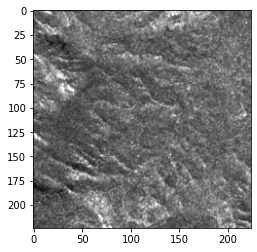

In [ ]:
x, y = next(iter(train_dataset))

## print one example
dim = x.shape[1]
print("Dimension of image:", x.shape, "\n", 
      "Dimension of labels", y.shape)

plt.imshow(x[160].reshape(1, 3, 224, 224).squeeze().T.numpy())

# Model Construction

Logistic regression models are fundamental building blocks of neural networks, thus they can also be considered the simplest of neural networks where the model performs a forward and abackward propagation to train the model on the data provided.

In [ ]:
class LR(nn.Module):
  def __init__(self, dim, lr=torch.scalar_tensor(0.01)):
     super(LR, self).__init__()
     # initialize the parameters
     self.w = torch.zeros(dim, 1, dtype=torch.float).to(device)
     self.b = torch.scalar_tensor(0).to(device)
     self.grads = {"dw":torch.zeros(dim, 1, dtype=torch.float).to(device),
                   "db":torch.scalar_tensor(0).to(device)}
     self.lr = lr.to(device)

  def forward(self, x):
    # compute forward propagation
    z = torch.mm(self.w.T, x)
    a = self.sigmoid(z)
    return a

  def sigmoid(self, z):
    return 1/(1+torch.exp(-z))

  def backward(self, x, yhat, y):
    # comput backward propagation
    self.grads["dw"] = (1/x.shape[1])*torch.mm(x, (yhat-y).T)
    self.grads["db"] = (1/x.shape[1])*torch.sum(yhat-y)

  def optimize(self):
    # optimization step
    self.w = self.w - self.lr * self.grads["dw"]
    self.b = self.b - self.lr * self.grads["db"]

# Utility functions for loss and prediction

def loss(yhat, y):
  m = y.size()[1]
  return -(1/m)*torch.sum(y*torch.log(yhat)+(1-y)*torch.log(1-yhat))

def predict(yhat, y):
  y_prediction = torch.zeros(1, y.size()[1])
  for i in range(yhat.size()[1]):
    if yhat[0, i] <= 0.5:
      y_prediction[0, i] = 0
    else:
      y_prediction[0, i] = 1
  return 100 - torch.mean(torch.abs(y_prediction - y)) * 100

**Test the model and make sure the right steps are taking place before training the entire model.**

In [ ]:
x, y = next(iter(train_dataset))

x_flatten = x.T
y = y.unsqueeze(0)

# the number of pixels is the dimension of the images
dim = x_flatten.shape[0]

# create a model instance
model = LR(dim)
model.to(device)
yhat = model.forward(x_flatten.to(device))
yhat = yhat.data.cpu()

# calculate the loss
cost = loss(yhat, y)
prediction = predict(yhat, y)
print("Cost: ", cost)
print("Accuracy: ", prediction)

# Backwards propagation
model.backward(x_flatten.to(device), yhat.to(device), y.to(device))
model.optimize()

Cost:  tensor(0.6931)
Accuracy:  tensor(25.9136)


**Model Training**

In [ ]:
# hyperparameters
costs = []
dim = x_flatten.shape[0]
learning_rate = torch.scalar_tensor(0.0001).to(device)
num_iterations = 100
lrmodel = LR(dim, learning_rate)
lrmodel.to(device)

# data transformation
def transform_data(x, y):
  x_flatten = x.T
  y = y.unsqueeze(0)
  return x_flatten, y

# model training
for i in range(num_iterations):
  x,y = next(iter(train_dataset))
  test_x, test_y = next(iter(test_dataset))
  x,y = transform_data(x,y)
  test_x, test_y = transform_data(test_x, test_y)

  # forward propagation
  yhat = lrmodel.forward(x.to(device))
  cost = loss(yhat.data.cpu(), y)
  train_pred = predict(yhat, y)

  # backward propagation
  lrmodel.backward(x.to(device),
                   yhat.to(device),
                   y.to(device))
  lrmodel.optimize()

  # test the model
  yhat_test = lrmodel.forward(test_x.to(device))
  test_pred = predict(yhat_test, test_y)

  if i % 10 == 0:
        costs.append(cost)

  if i % 10 == 0:
        print("Cost after iteration {}: {} | Train Acc: {} | Test Acc: {}".format(i, 
                                                                                    cost, 
                                                                                    train_pred,
                                                                                    test_pred))



  


Cost after iteration 0: 0.6931472420692444 | Train Acc: 25.913619995117188 | Test Acc: 70.12986755371094
Cost after iteration 10: 0.6310676336288452 | Train Acc: 70.09967041015625 | Test Acc: 70.12986755371094
Cost after iteration 20: 0.6276116371154785 | Train Acc: 70.09967041015625 | Test Acc: 70.12986755371094
Cost after iteration 30: 0.6245264410972595 | Train Acc: 70.76411437988281 | Test Acc: 70.12986755371094
Cost after iteration 40: 0.6216323375701904 | Train Acc: 70.76411437988281 | Test Acc: 70.12986755371094
Cost after iteration 50: 0.6189031004905701 | Train Acc: 70.76411437988281 | Test Acc: 70.12986755371094
Cost after iteration 60: 0.6163176894187927 | Train Acc: 70.76411437988281 | Test Acc: 70.12986755371094
Cost after iteration 70: 0.6138581037521362 | Train Acc: 70.09967041015625 | Test Acc: 68.83116912841797
Cost after iteration 80: 0.6115097999572754 | Train Acc: 69.76744079589844 | Test Acc: 68.83116912841797
Cost after iteration 90: 0.6092602014541626 | Train Acc

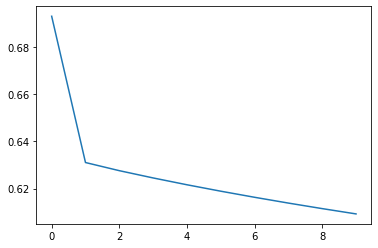

In [ ]:
# the trend in the context of loss
plt.plot(costs)
plt.show()